In [63]:
%pwd

'/home/acr/Documents/Projeto Sistemas Mecatrónicos/RL-SistMecatron/Resultados e Código para Relatório'

# Runs on Python 3.9. Keras RL doesn't run on python 3.7

# Building our own scenario

Build a reinforcement learning model to adjust the temperature automatically to get in the optimal range

Optimal temperature: Between 37 and 39 degrees
Shower Length: 60 seconds
Actions: Turn down, Leave, Turn up
Task: Build a model that keeps us in the optimal range for as long as possible

# Install Dependencies

In [33]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.3.0


# Creating a random environment

#### The goal is to balance the pole up, moving the cart to the left or right . For each step it takes a point, for a maximum of 200 points

In [35]:
from gym import Env # Allows us to build our environment on top of it
from gym import spaces
from gym.spaces import Discrete, Box # Allows us to define the actions and the states of our environment
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [36]:
class ShowerEnv(Env): # By passing Env to the showerEnv class we are inheriting the methods and properties from the OpenAI gym environment class
    def __init__(self): # We will be initializing the actions we can take, our observation space, the space, the temperature and the shower length 
        # Actions we can take, down, stay, up
        self.action_space=Discrete(3)
        # Temperature array
        self.observation_space = Box(low=np.array([0]), high=np.array([100])) # Box allows to gave a whole range of spaces
        # Set start temp (As in real life, the shower's water starts cold)
        self.state = 15 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 60*5 # 10 minutes=10*60 seconds
        
    def step(self, action): # Defines what we do whenever we take actions
        # Aplly action
        # As the action is 0,1 or 2, as we subtract 1 when temperature decreases is -1, when it stays the same is 0 and when it increases is +1
        # 0-1=-1, 1-1=0, 2-1=1
        self.state += action -1
        # Reduce shower length by 1 second
        self.shower_length -= 1
        
        #Calculate reward
        # If water is 38 it gives a reward of 2, if it is 37 or 29 it gives a reward of 1
        if self.state>= 37 and self.state<=39:
            reward= (2-abs(38-self.state))*6
        # The negative rewards will be greater if the colder the water is and the hotter the water is 
        elif self.state < 37:
            reward=-(37-self.state)*2
        elif self.state > 39:
            reward = -(self.state-39)*2
        
        # Check if shower is done
        if self.shower_length <=0 :
            done = True
        else:
            done = False                
        
        # Apply temperature noise
#         self.state+=random.randint(-2,2)
        # Set placeholder for info
        info= {}
        
        # Return step information
        return self.state, reward, done, info # self.state is the temperature
    
    def render(self): # Visualizations
        # Implement visualization
        pass
    def reset(self):
        # Reset shower temperature
        self.state = 15 +random.randint(-3,3)
        # Reset shower time
        self.shower_length = 60*5
        return self.state
    

In [37]:
env = ShowerEnv()

/home/acr/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [38]:
# help(env.step)

In [39]:
env.step(1)[0]

13

In [40]:
env.action_space.sample()

1

In [41]:
env.observation_space.high[0]

100.0

In [42]:
env.observation_space.sample()

array([14.772073], dtype=float32)

#### Now we're just setting some random episodes where there is no learning from each of the episodes

Box([0.], [100.], (1,), float32)
Discrete(3)
0

Episode:1 Score: -15692 
Episode:2 Score: -16842 
Episode:3 Score: -16144 
Episode:4 Score: -13522 
Episode:5 Score: -12626 
Episode:6 Score: -6372 
Episode:7 Score: -14868 
Episode:8 Score: -9288 
Episode:9 Score: -14568 
Episode:10 Score: -6692 


<function matplotlib.pyplot.show(close=None, block=None)>

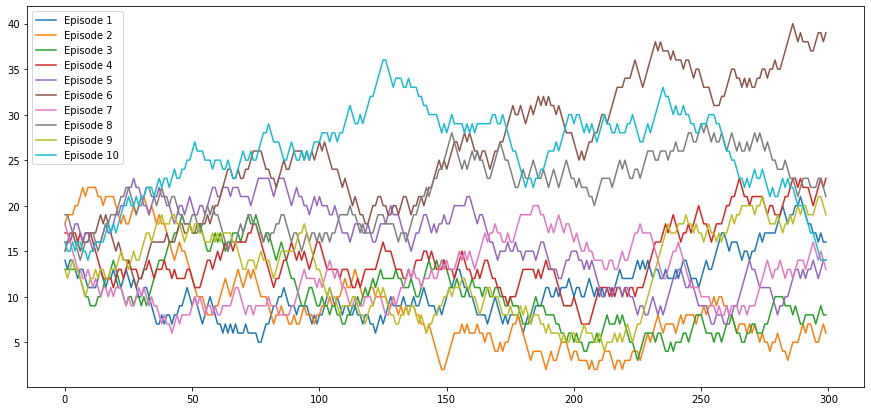

In [43]:
obs = env.reset()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())
print()

plt.figure(figsize=(15,7))
episodes = 10
for episode in range(1,episodes+1):
  state=env.reset()
  done=False
  score=0
  Temp_plot=[]

  while not done:
#     env.render() # Rendering of the screen
#     time.sleep(0.03) # Slowing the rendering. It stops 0.03 seconds for each frame
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    Temp_plot.append(obs)
    score+=reward
    info = info
    
  plt.plot(Temp_plot, label = 'Episode {}'.format(episode))
  plt.legend()
  print('Episode:{} Score: {} '.format(episode, round(score,0)))
plt.show
# env.close()   # Closing the video, otherwise the window will not close

In [44]:
# help(env.step)

# Create a Deep Learning Model with Keras

#### Ideally we want to take the score of each episode all the way up to 200. The deep RL is going to learn the best action to take in that specific environment to maximize the score

In [45]:
import numpy as np
import tensorflow  #allows a sequential model with Keras
# It's better to import tensorflow and use sequential than specifically importing the sequential from tensorlfow.keras.model
from tensorflow.keras.layers import Dense, Flatten # We've imported the dense and flattten nodes
from tensorflow.keras.optimizers import Adam # We've imported the optimizer Adam to train the deep learning model

In [46]:
states = env.observation_space.shape
actions = env.action_space.n

In [47]:
states

(1,)

In [48]:
env.observation_space

Box([0.], [100.], (1,), float32)

In [49]:
def build_model3layers(states, actions):
  model = tensorflow.keras.Sequential()  # initiating a sequential model
  model.add(Dense(24, activation='relu', input_shape=states))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(actions, activation='linear')) # This makes sure that the output are the actions. First (or through the top), come the states and lastly comes the acitons
  return model
# This model is fed the states and gets out the actions, and it trains in order to maximize the reward

In [50]:
del model_a

In [51]:
model_a = build_model3layers(states,actions)

In [52]:
model_a.summary() # The final output will have 3 actions. Decreasing, staying the same and increasing the temperature

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                48        
                                                                 
 dense_9 (Dense)             (None, 24)                600       
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 3)                 75        
                                                                 
Total params: 1,323
Trainable params: 1,323
Non-trainable params: 0
_________________________________________________________________


# Build Agent with Keras-RL

In [53]:
from rl.agents import DQNAgent # Agent from keras rl, there are several
from rl.policy import BoltzmannQPolicy # There are two types of policies, the value-based rl and policy-based rl. This case will use policy based policy. This is the boltzmann Qpolicy
from rl.memory import SequentialMemory # For the DQNAgent there is the need for some memory, the Sequential memory allow it

In [54]:
def build_agent3layers(model, actions):
  policy_a = BoltzmannQPolicy()
  memory_a = SequentialMemory(limit=50000, window_length=1)
  dqn = DQNAgent(model=model_a, memory=memory_a, policy=policy_a, 
                 nb_actions=actions, nb_steps_warmup=50, target_model_update=1e-2)
  return dqn

In [55]:
# help(DQNAgent)

In [56]:
dqn = build_agent3layers(model_a,actions) # Agent initiated. It knows the model, where it has the environment, and the actions it is allowed to do 
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae']) # Compile the model through optimizer

In [57]:
dqn.load_weights('dqn_RL_Example_Custom_Scenario_Variations_1action_NoNoise_KerasRL_RewardsTweak_model_300kSteps')
# dqn.fit(env, nb_steps=300000, visualize=False, verbose=1)

# The reward should be improved along the intervals

In [58]:
# dqn.save_weights('dqn_RL_Example_Custom_Scenario_Variations_1action_NoNoise_KerasRL_RewardsTweak_model_300kSteps',overwrite=False)

In [59]:
# dqn.load_weights('dqn_RL_Example_Custom_Scenario_Variations_1action_NoNoise_KerasRL_RewardsTweak_model_150kSteps')

The model will never hit a perfect run as the we have some noise being applied and the model only allow to having one degree being changed at a time. This is something that could be improved for future research

In [60]:
print('For the deep learning model with 3 layers.')
scores = dqn.test(env,nb_episodes=100, visualize=False)
print('\nAverage Episode Reward: {}'.format(np.mean(scores.history['episode_reward'])))

For the deep learning model with 3 layers.
Testing for 100 episodes ...
Episode 1: reward: 2824.000, steps: 300
Episode 2: reward: 2824.000, steps: 300
Episode 3: reward: 2824.000, steps: 300
Episode 4: reward: 2986.000, steps: 300
Episode 5: reward: 2706.000, steps: 300
Episode 6: reward: 2934.000, steps: 300
Episode 7: reward: 2986.000, steps: 300
Episode 8: reward: 2934.000, steps: 300
Episode 9: reward: 2880.000, steps: 300
Episode 10: reward: 2934.000, steps: 300
Episode 11: reward: 2880.000, steps: 300
Episode 12: reward: 2706.000, steps: 300
Episode 13: reward: 2824.000, steps: 300
Episode 14: reward: 2986.000, steps: 300
Episode 15: reward: 3036.000, steps: 300
Episode 16: reward: 2880.000, steps: 300
Episode 17: reward: 2766.000, steps: 300
Episode 18: reward: 2706.000, steps: 300
Episode 19: reward: 3036.000, steps: 300
Episode 20: reward: 2934.000, steps: 300
Episode 21: reward: 2766.000, steps: 300
Episode 22: reward: 2766.000, steps: 300
Episode 23: reward: 2824.000, steps


State: 15
Action:  1
State 16 reward= -42 done= False
Sum of rewards: -42
Step: 1

State: 16
Action:  1
State 17 reward= -40 done= False
Sum of rewards: -82
Step: 2

State: 17
Action:  1
State 18 reward= -38 done= False
Sum of rewards: -120
Step: 3

State: 18
Action:  1
State 19 reward= -36 done= False
Sum of rewards: -156
Step: 4

State: 19
Action:  1
State 20 reward= -34 done= False
Sum of rewards: -190
Step: 5

State: 20
Action:  1
State 21 reward= -32 done= False
Sum of rewards: -222
Step: 6

State: 21
Action:  1
State 22 reward= -30 done= False
Sum of rewards: -252
Step: 7

State: 22
Action:  1
State 23 reward= -28 done= False
Sum of rewards: -280
Step: 8

State: 23
Action:  1
State 24 reward= -26 done= False
Sum of rewards: -306
Step: 9

State: 24
Action:  1
State 25 reward= -24 done= False
Sum of rewards: -330
Step: 10

State: 25
Action:  1
State 26 reward= -22 done= False
Sum of rewards: -352
Step: 11

State: 26
Action:  1
State 27 reward= -20 done= False
Sum of rewards: -372



State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1512
Step: 186

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1524
Step: 187

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1536
Step: 188

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1548
Step: 189

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1560
Step: 190

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1572
Step: 191

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1584
Step: 192

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1596
Step: 193

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1608
Step: 194

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1620
Step: 195

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 1632
Step: 196

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewa


State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2736
Step: 288

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2748
Step: 289

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2760
Step: 290

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2772
Step: 291

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2784
Step: 292

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2796
Step: 293

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2808
Step: 294

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2820
Step: 295

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2832
Step: 296

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2844
Step: 297

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewards: 2856
Step: 298

State: 38
Action:  0
State 38 reward= 12 done= False
Sum of rewa

<function matplotlib.pyplot.show(close=None, block=None)>

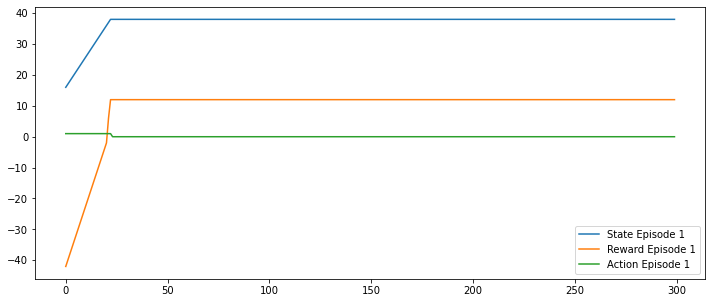

In [61]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action = dqn.forward(obs)
    print('\nState:',obs)
    print("Action: ", action-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs, 'reward=', rewards, 'done=', done)
    state_batch.append(obs)
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards)
    print('Sum of rewards:', total_rewards)
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch, label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

In [62]:
# help(dqn.test(env))